In [5]:
import numpy as np
import math as m
import scipy.linalg as linalg
from scipy import stats
from timeit import default_timer
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
def N(x):
    return stats.norm.cdf(x, 0.0, 1.0)

def bsm_d1(S, K, T, r, sigma):
    S = float(S)
    return (m.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_d2(S, K, T, r, sigma):
    S = float(S)
    return (m.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * m.sqrt(T))

def bsm_call_pv(S, K, T, r, sigma):
    d1 = bsm_d1(S, K, T, r, sigma)
    d2 = bsm_d2(S, K, T, r, sigma)
    return S * N(d1) - K * m.exp(-r * T) * N(d2)

def bsm_call_delta(S, K, T, r, sigma):
    d1 = bsm_d1(S, K, T, r, sigma)
    return N(d1)

S0 = 80.; K = 85.; T = 1.; r = 0.05; 
sigma = 0.2

Smax = 110.

ref_pv = bsm_call_pv(S0, K, T, r, sigma)

print( "ref_pv: %.6f " % (ref_pv) )

ref_pv: 5.988244 


In [1]:
def priceWithPDE0(S0, K, r, T, sigma, M, N, Smax, is_call=True):
    M, N = int(M), int(N)
    dS = float(Smax) / M
    dt = float(T) / N
    k_values = np.arange(M)
    j_values = np.arange(N)
    grid = np.zeros(shape=(M+1, N+1))
    S = np.linspace(0, Smax, M+1)

    # setup boundary conditions
    if is_call:
        grid[:, -1] = np.maximum(S - K, 0)
        grid[-1, :-1] = Smax - K* np.exp(-r *dt*(N-j_values))
    else:
        grid[:, -1] = np.maximum(K-S, 0)

        grid[0, :-1] = K * np.exp(-r *dt *(N-j_values))

    # calculate coefficients and matrix to solve
    alpha = 0.25*dt*((sigma**2)*(k_values**2) -r*k_values)

    beta = -dt*0.5*(
        (sigma**2)*(k_values**2) + r)         

    gamma = 0.25*dt*((sigma**2)*(k_values**2) +r*k_values)
    

    A1 = -np.diag(alpha[2:M], -1) + \
        np.diag(1-beta[1:M]) - np.diag(gamma[1:M-1], 1)

    A2 = np.diag(alpha[2:M], -1) + \
        np.diag(1+beta[1:M]) + np.diag(gamma[1:M-1], 1)
        
    #print(A1, "A1")
    #print(A2, "A2")

    print(f"{alpha.shape} {beta.shape} {gamma.shape}")
    print(f"{A1.shape} {A2.shape}")
    
    # solve systems of linear equstions 
    for j in reversed(range(N)):
        B = A2 @ grid[1:M, j+1]
        #B[0] = alpha[0]*(grid[0,j+1] + grid[0,j])
        #B[-1] = gamma[M-1]*(grid[-1,j+1] + grid[-1,j])
        x2 = linalg.solve(A1, B)
        grid[1:M, j] = x2

    # use linear interpolation to get result value 
    pv_0 = np.interp(S0, S, grid[:, 0])
    return pv_0, grid, S 
    
S0 = 80.; K = 85.; T = 1.0; r = 0.05; q = 0.0; sigma = 0.2
Smax = 160.

start = default_timer()
pv, grid, S = priceWithPDE0(S0=S0, K=K, r=r, T=T, sigma=sigma,M=100, N=100, Smax=Smax, is_call=True)
calcTime = default_timer() - start

print( "PV: %.5f, abs diff: %.5f, rel diff:  %.5f" % (pv, ref_pv - pv, (ref_pv - pv)/ref_pv) )
print( "Calculation time   %.5f" % calcTime )

NameError: name 'default_timer' is not defined

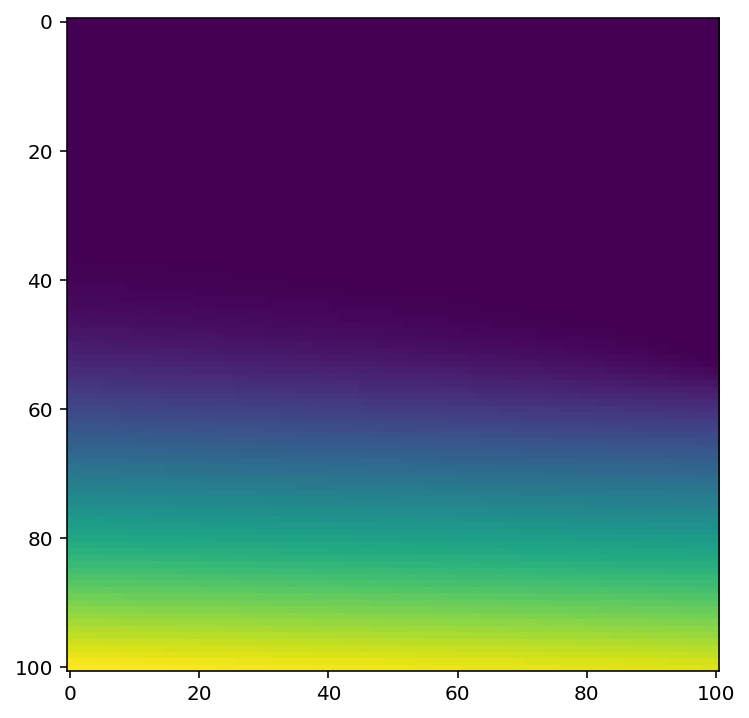

In [14]:
plt.figure(figsize=(12, 6))
plt.imshow(grid)

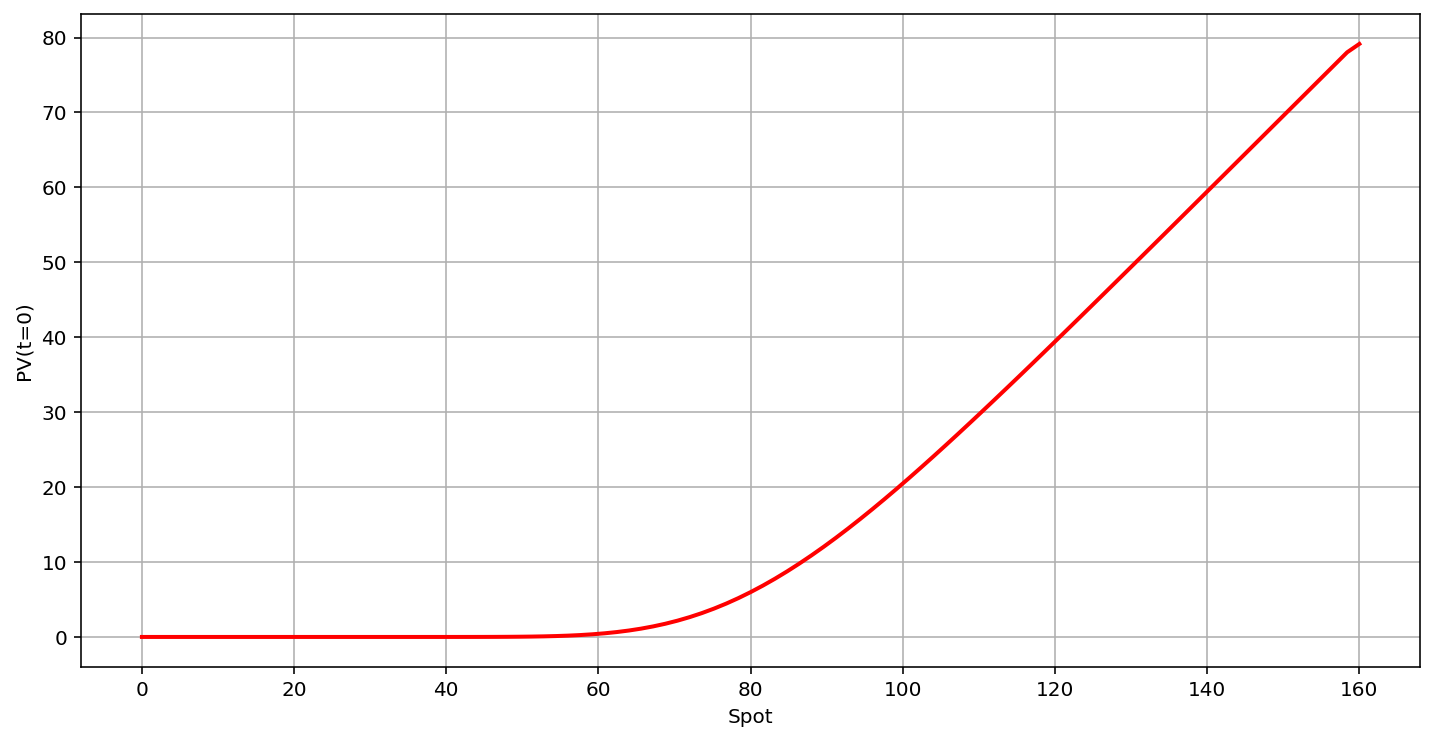

In [5]:
pv = grid[:, 0]
S_ = S[:]

plt.figure(figsize=(12, 6))
plt.plot(S_, pv, 'r', linewidth=2)
plt.xlabel('Spot')
plt.ylabel('PV(t=0)')
plt.grid(True)

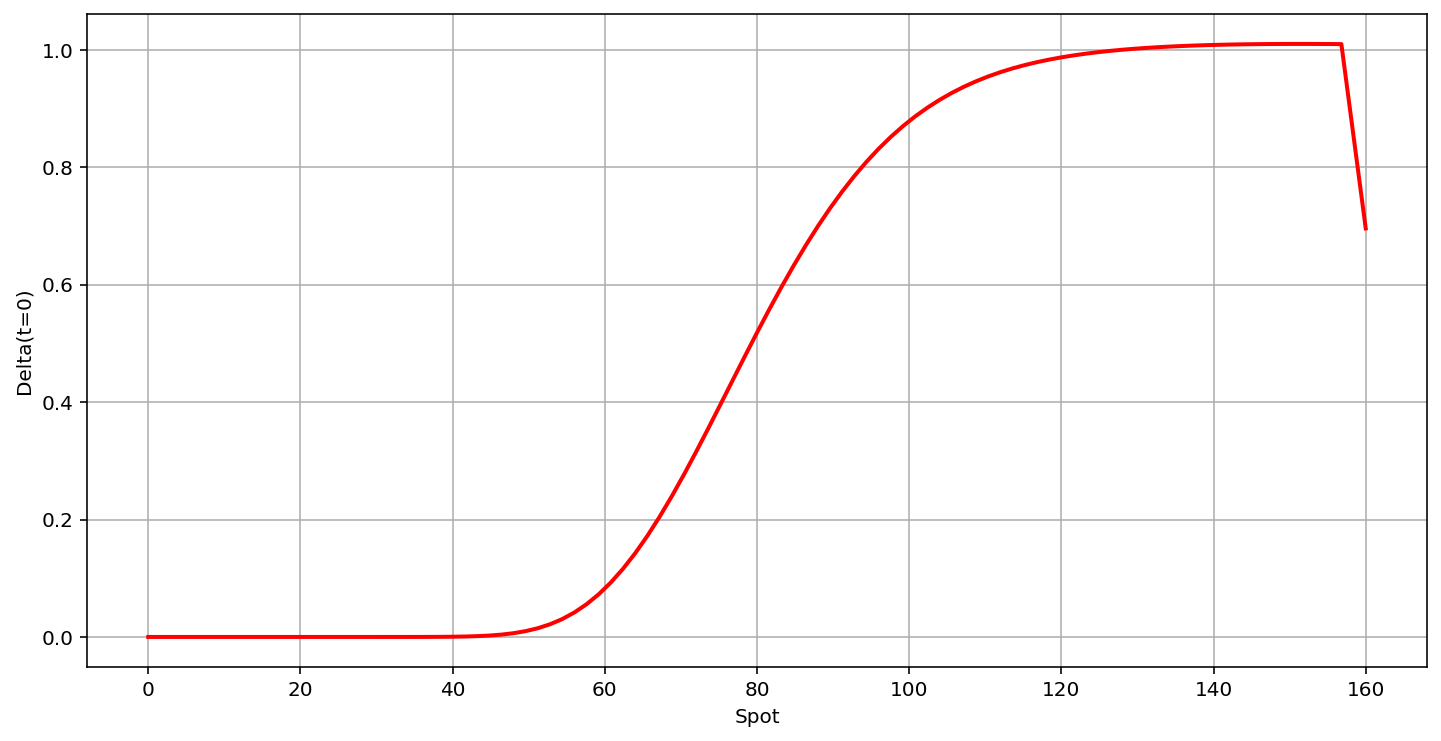

In [6]:
delta = np.zeros(shape=len(S_))
dS = S_[1] - S_[0]

for i in range(1, len(delta)-1):
    delta[i] = (pv[i+1] - pv[i-1]) / (2. * dS)
delta[0] = (pv[1] - pv[0]) / dS
delta[-1] = (pv[-1] - pv[-2]) /dS

plt.figure(figsize=(12, 6))
plt.plot(S_, delta, 'r', linewidth=2)
plt.xlabel('Spot')
plt.ylabel('Delta(t=0)')
plt.grid(True)